In [91]:
%%bash
cd ../firmware/mcu/semester-project-ascon/
make PLATFORM=CW312_SAM4S CRYPTO_TARGET=NONE

Building for platform CW312_SAM4S with CRYPTO_TARGET=NONE
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (Arm GNU Toolchain 14.3.Rel1 (Build arm-14.174)) 14.3.1 20250623
Copyright (C) 2024 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CW312_SAM4S 
.
Compiling:
-en     simpleserial-ascon.c ...
-e Done!
.
Compiling:
-en     ascon.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/hal.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/startup_sam4s.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/sam4s_hal.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/uart.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/pio.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/system_sam4s.c ...
-e Done!


In [90]:
import chipwhisperer as cw
scope = cw.scope()
target = cw.target(scope)
scope.default_setup()

scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 22                       
scope.gain.db                            changed from 15.0                      to 25.091743119266056       
scope.adc.samples                        changed from 131124                    to 5000                     
scope.clock.clkgen_freq                  changed from 0                         to 7363636.363636363        
scope.clock.adc_freq                     changed from 0                         to 29454545.454545453       
scope.io.tio1                            changed from serial_tx                 to serial_rx                
scope.io.tio2                            changed from serial_rx                 to serial_tx                
scope.io.hs2                             changed from None                      to clkgen                   
scope.io.cdc_settin

In [92]:
cw.program_target(scope, cw.programmers.SAM4SProgrammer, "/Users/metehankoc/Desktop/SECCLO/EURECOM/Semester Project/chipwhisperer/firmware/mcu/semester-project-ascon/simpleserial-ascon-CW312_SAM4S.hex")

Using fixed key: d7d45cb5d238be2bd1046a709255cb5b
Capturing 50 traces...


  0%|          | 0/50 [00:00<?, ?it/s]

Capture complete. Disconnected from scope and target.

Captured Traces Shape: (50, 3000)
Plaintext Shape: (50,)
Ciphertext Shape: (50, 32)


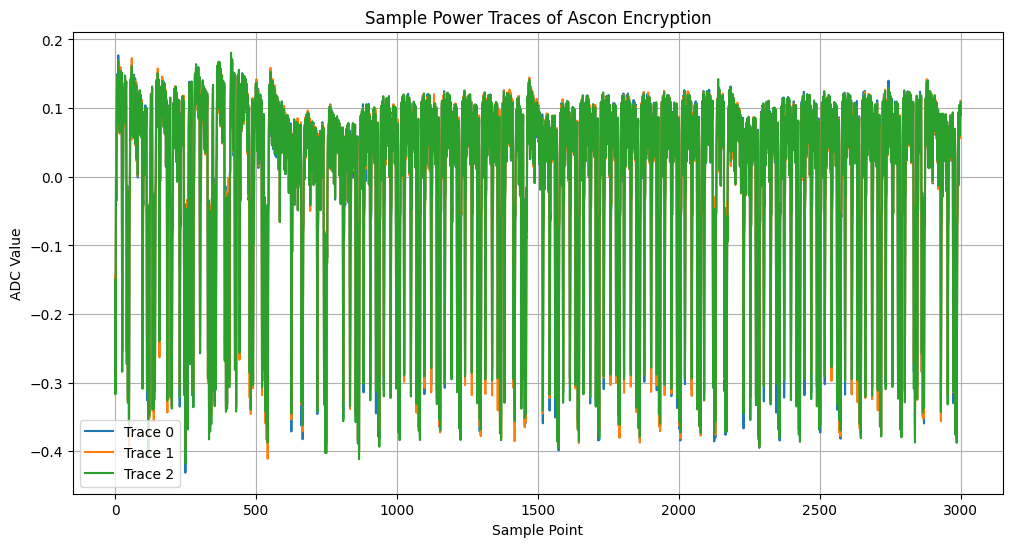

In [93]:
import chipwhisperer as cw
import numpy as np
import os
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import time

# Number of traces to capture
num_traces = 50

# Configure the scope for the SAM4S target
scope.default_setup()
scope.gain.db = 25
scope.adc.samples = 3000  # adjust for trace length
scope.adc.presamples = 0
scope.trigger.triggers = "tio4"  # external trigger from target

trace_array = []
plaintext_array = []
ciphertext_array = []

# ✅ Generate ONE key for all traces
fixed_key = os.urandom(16)
print(f"Using fixed key: {fixed_key.hex()}")
target.simpleserial_write('k', fixed_key)

print(f"Capturing {num_traces} traces...")

for i in trange(num_traces):
    nonce = os.urandom(16)
    plaintext = b"\x00" * 16

    scope.arm()

    target.simpleserial_write('e', nonce + plaintext)

    # Capture trace
    if scope.capture():
        print(f"[{i}] Trigger not seen! Skipping trace.")
        continue

    wave = np.array(scope.get_last_trace()).astype(np.float32)

    # Read ciphertext from target
    response = target.simpleserial_read('r', 32)
    if response is None or len(response) != 32:
        response = bytearray(32)

    trace_array.append(wave)
    plaintext_array.append(plaintext)
    ciphertext_array.append(response)

# --- Clean up ---
scope.dis()
target.dis()
print("Capture complete. Disconnected from scope and target.")

# --- Convert lists to NumPy arrays ---
traces = np.array(trace_array)
plaintexts = np.array(plaintext_array)
ciphertexts = np.array(ciphertext_array)

print(f"\nCaptured Traces Shape: {traces.shape}")
print(f"Plaintext Shape: {plaintexts.shape}")
print(f"Ciphertext Shape: {ciphertexts.shape}")

# --- Example Plotting ---
plt.figure(figsize=(12, 6))
plt.plot(traces[0], label="Trace 0")
plt.plot(traces[1], label="Trace 1")
plt.plot(traces[2], label="Trace 2")
plt.title("Sample Power Traces of Ascon Encryption")
plt.xlabel("Sample Point")
plt.ylabel("ADC Value")
plt.legend()
plt.grid(True)
plt.show()


In [86]:

scope.dis()
target.dis()

In [94]:
print(ciphertexts)

[[ 41  41  29 ... 111 238 102]
 [221 222   5 ...   6 132 248]
 [151 217 123 ... 108  76 104]
 ...
 [206 167  40 ... 231  52  53]
 [211 157 168 ... 238  86 153]
 [224 196  51 ...  89 115 113]]
